In [1]:
import torch
from flytracker import run

from flytracker.utils.param_helpers import load_frame, test_mask, test_threshold
from skimage.filters import threshold_local
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted

import os

%load_ext autoreload
%autoreload 2

To split video:
ffmpeg -i seq_1.mp4 -c copy  -segment_time 00:10:00 -f segment -reset_timestamps 1 split/seq_%02d.mp4

In [2]:
movie_path =  "../../data/experiments/bruno/videos/split/seq_00.mp4"
all_movies = "../../data/experiments/bruno/videos/split/mini_split"

In [3]:
image = load_frame(movie_path, frame=100, color=False)

In [4]:
mask = torch.ones((1080, 1280), dtype=bool)
mask[:130, :] = 0
mask[-160:, :] = 0
mask[:, :270] = 0
mask[:, -205:] = 0

mask[:190, :350] = 0
mask[:195, -270:] = 0
mask[-220:, :340] = 0
mask[870:, 1010:] = 0


In [5]:
def local_threshold(image, mask, threshold=50, block_size=31):
    background = threshold_local(image, block_size=block_size, method='median', )
    # we apply the mask after the background to avoid annoying edge effects
    background = test_mask(torch.tensor(background, dtype=torch.uint8), mask)
    return background - threshold 

In [6]:
local_threshold = local_threshold(image, mask, 40, 31) # feed in unmasked image!

# Baseline - completely

In [7]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    n_ini=100,
    threshold=local_threshold,
)

/home/gert-jan/Documents/flyTracker/src/flytracker/tracker.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold).to(device, non_blocking=True),


Done with frame 1000
Done with frame 2000
Done with frame 3000
Done with frame 4000
Done with frame 5000
Done with frame 6000
Done with frame 7000
Done with frame 8000
Done with frame 9000
Done with frame 10000
Done with frame 11000
Done with frame 12000
Done with frame 13000
Done with frame 14000
Done with frame 15000
Done with frame 16000
Done with frame 17000
Done with frame 18000
CPU times: user 16min 12s, sys: 576 ms, total: 16min 13s
Wall time: 1min 39s


In [8]:
len(df)

1

In [9]:
df_baseline = df[0]

In [17]:
df_baseline.frame.unique().size

5146

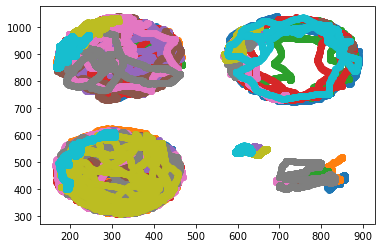

In [10]:
min_frame = 0
for ID in df_baseline.ID.unique():
    plt.plot(df_baseline.query(f"ID=={ID} and frame > {min_frame}")["x"], df_baseline.query(f"ID=={ID} and frame > {min_frame}")["y"], 'o')

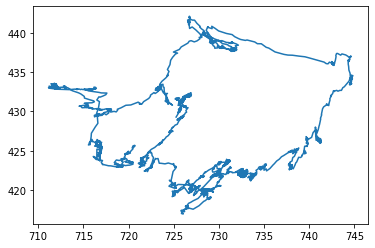

In [12]:
ID = 5
plt.plot(df_baseline.query(f"ID=={ID}")["x"], df_baseline.query(f"ID=={ID}")["y"])

In [43]:
df_baseline.frame.unique().size

5146

# Multiple

In [10]:
%%time
df = run(
    all_movies,
    mask,
    n_arenas=4,
    gpu=True,
    n_ini=100,
    threshold=local_threshold,
)

/home/gert-jan/Documents/flyTracker/src/flytracker/tracker.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold).to(device, non_blocking=True),


100 100
Done with frame 1000


/home/gert-jan/Documents/flyTracker/src/flytracker/tracker.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_array[0, :, :2] = torch.tensor(init, dtype=torch.float32)


Done with frame 0
Done with frame 1000
Done with frame 0
Done with frame 1000
Done with frame 0
Done with frame 1000
CPU times: user 7min 57s, sys: 708 ms, total: 7min 58s
Wall time: 32.5 s


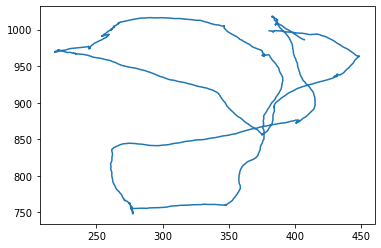

In [15]:
ID = 30
plt.plot(df.query(f"ID=={ID}")["x"], df.query(f"ID=={ID}")["y"], '-')

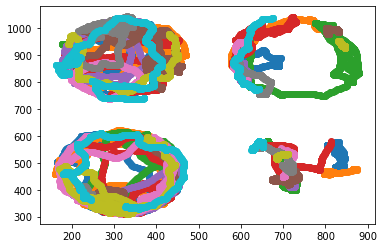

In [16]:
min_frame = 0
for ID in df.ID.unique():
    plt.plot(df.query(f"ID=={ID} and frame > {min_frame}")["x"], df.query(f"ID=={ID} and frame > {min_frame}")["y"], 'o')